In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pyBigWig as bw
from scipy.stats import beta
import re
import os
import time
import multiprocessing as mp

ncols = 7
nrows = 3

gtf = '../resources/genome/GRCm39/gene_protein_coding.gtf'
circadian_core_genes = pd.read_csv(gtf, sep='\t', header=None)
circadian_core_genes.columns = ['chr', 'source', 'feature', 'start', 'end', 'score', 'strand', 'frame', 'attribute']

# Function to extract gene_name
def extract_attribute(entry,attribute):
    match = re.search(rf'{attribute} "([^"]+)"', entry)
    if match:
        return match.group(1)
    else:
        return None
    
circadian_core_genes['gene_name'] = circadian_core_genes['attribute'].apply(extract_attribute,attribute='gene_name')
circadian_core_genes['gene_id'] = circadian_core_genes['attribute'].apply(extract_attribute,attribute='gene_id')

# keep only circadian core genes
my_genes = pd.read_csv('../resources/core_circadian_clock_genes.txt',sep='\t',usecols=[0])
my_genes = np.sort(my_genes.mm10.values)

idx = circadian_core_genes.gene_name.isin(my_genes)
circadian_core_genes = circadian_core_genes[idx]
circadian_core_genes.set_index('gene_name',inplace=True)
circadian_core_genes.sort_index(inplace=True)

Phase_amp = {}

def FourierTransform(x,T,ω):

    N = T.shape[0]
    f_n = np.sum(x*np.exp(-1j*ω*T),1)
    a_n = 4/N * np.abs(f_n)
    φ_n = -np.arctan2(np.imag(f_n),np.real(f_n)) # ?? -im/re ??
    μ = 1/N * np.sum(x,1)

    x_hat = μ[:,None] + 0.5 * a_n[:,None] * np.cos(ω * T[None,:] - φ_n[:,None])
    sig2_res = np.var(x - x_hat,1)
    sig2_tot = np.var(x,1)
    R2 = np.zeros(sig2_res.shape)
    R2[sig2_tot==0] = 0
    R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    φ_n[φ_n<0] += np.pi * 2

    return φ_n, a_n, R2, pval, μ

### RNA-seq

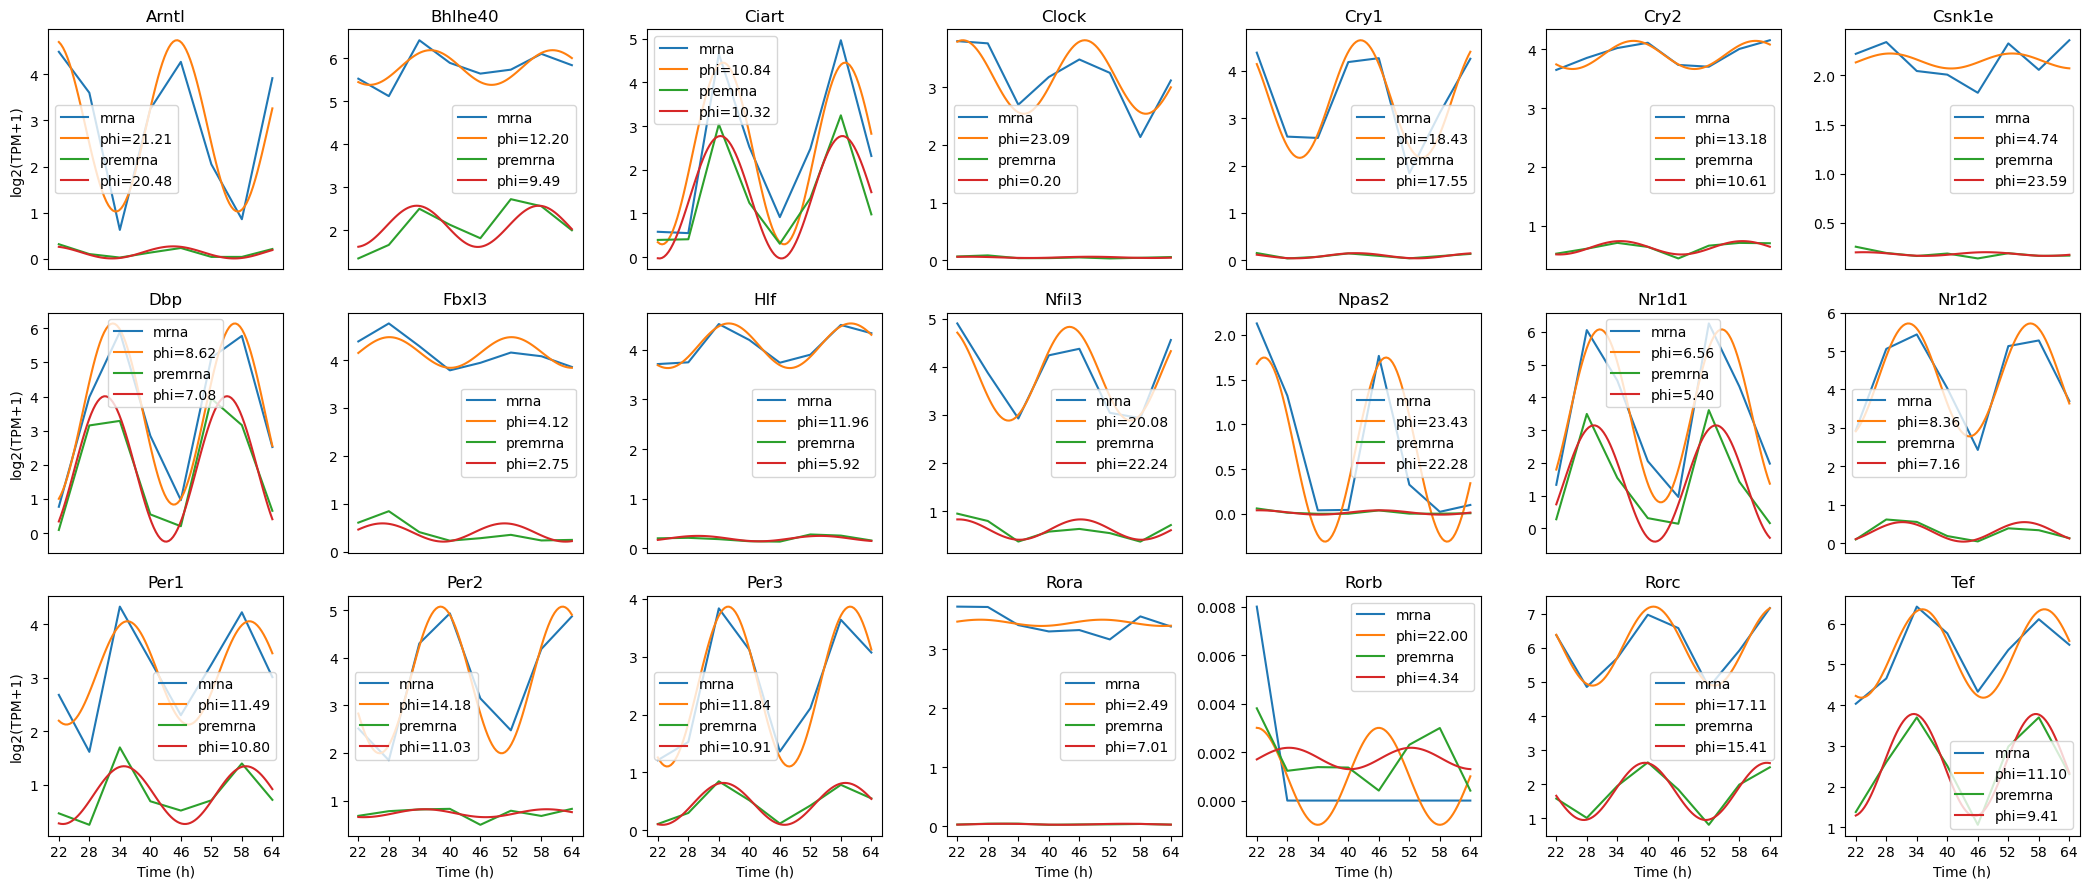

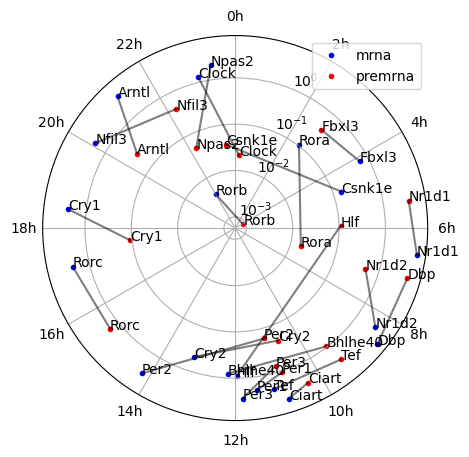

In [33]:
# Load rna-seq data
rnaseq = {}
rnaseq_full_gene_id = {}
T = np.arange(22,65,6)
cols = [f'Liv_CT{t}' for t in T]
for i in ['mrna','premrna']:
    rnaseq[i] = pd.read_csv(f'../../RNAseq/results/Zhang_PNAS_2014/kallisto/{i}_tpm_table.tab', sep='\t', index_col=0)

    # Keep only Liver samples
    rnaseq[i] = rnaseq[i][cols]

# Keep only circadian core genes
gene_id = np.array([id.split('|')[1] for id in rnaseq['mrna'].index])
idx = []
new_index = []
for g in circadian_core_genes.index:
    tmp = np.where(np.array(gene_id) == circadian_core_genes.loc[g].gene_id)[0]
    idx.extend(list(tmp))
    new_index.extend([g]*len(tmp))

for i in ['mrna','premrna']:   
    rnaseq[i] = rnaseq[i].iloc[idx]
    rnaseq[i].index = new_index

    # sum all row with same gene index and take the log
    rnaseq[i] = rnaseq[i].groupby(rnaseq[i].index).sum().apply(lambda x: np.log2(x+1))

# fourier transform
N = rnaseq['mrna'].shape[1]
T = np.arange(22,65,6)
P = 24
n = 1
ω_n = 2*np.pi*n/P

for i in ['mrna','premrna']:

    Phase_amp[i] = pd.DataFrame( np.zeros((circadian_core_genes.shape[0],5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
    Phase_amp[i].index = circadian_core_genes.index

    x = rnaseq[i].values
    φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

    # make table
    Phase_amp[i].loc[:,'phase'] = φ_n
    Phase_amp[i].loc[:,'amplitude'] = a_n
    Phase_amp[i].loc[:,'R2'] = R2
    Phase_amp[i].loc[:,'pval'] = pval
    Phase_amp[i].loc[:,'mean_log_expression'] = mu


# plot all phase and amplitude in a polar plot
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*3,nrows*3))

t_ = np.linspace(22,64,100,endpoint=True)

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['mrna','premrna']:
        ax.plot(T,rnaseq[i].loc[g],label=i)
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}')

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(T)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.legend()

    ax.set_title(g)

fig.tight_layout()


fig, ax = plt.subplots(figsize=(5,5),subplot_kw={'projection': 'polar'})
colors = {'mrna':'blue','premrna':'red'}
for i in ['mrna','premrna']:
    ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,label=i,color=colors[i],marker='.')
    # add names
    for g in Phase_amp[i].index:
        ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g)

# connect same gene pre-mRNA and mRNA with thin line
for g in Phase_amp['mrna'].index:
    ax.plot([Phase_amp['mrna'].loc[g].phase,Phase_amp['premrna'].loc[g].phase], [Phase_amp['mrna'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude], color='black', alpha=0.5)

ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')
ax.legend()


### PRO-seq

In [108]:
# get circadian core genes coordinates

Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
T = np.arange(0,48,4)
Nt = len(T)
Samples = ['CT{:02d}'.format(t) for t in T]

# get pro-seq count tables
infolder = '../results/norm_coverage'

# output folder for genes bedgraph
outfold = 'genes_bedgraph'

def get_gene_by_coord(args):
    [chr,start,end,fin,fout] = args
    if not os.path.exists(fout):
        os.system(f'./get_gene_by_coord.sh {chr} {start} {end} {fin} {fout}')
    return 0

args = []
for g in circadian_core_genes.index:
    [chr,start,end,strand] = circadian_core_genes.loc[g,['chr','start','end','strand']]
    for t in T:
        sample = f'CT{t:02d}'
        fin = f'{infolder}/{sample}/NormCoverage_3p_{strand_dict[strand]}.bedgraph'
        fout = f'{outfold}/{g}_{sample}.bedgraph'
        args.append([chr,start,end,fin,fout])

# run in parralel
with mp.Pool(processes=48) as pool:
    out = pool.map(get_gene_by_coord,args)

proseq = {}
for g in circadian_core_genes.index:
    proseq[g] = pd.DataFrame(columns=['chr','start','end'])
    for t in T:
        sample = f'CT{t:02d}'
        fin = f'{outfold}/{g}_{sample}.bedgraph'

        df_t = pd.read_csv(fin,sep='\t',header=None)
        df_t.columns = ['chr','start','end',sample]

        proseq[g] = pd.merge(proseq[g],df_t,on=['chr','start','end'],how='outer')
    proseq[g].set_index('start',inplace=True)
    proseq[g] = proseq[g].loc[:,Samples]


# sum counts in gene body
samples = [f'CT{t:02d}' for t in T]
tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
tpm.columns = samples
tpm.index = proseq.keys()
log_tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
for g in proseq:
    tpm.loc[g] = proseq[g].fillna(0).sum(0)
    log_tpm = np.log2(tpm+1)

Phase_amp['proseq_logtpm'] = pd.DataFrame( np.zeros((len(proseq),5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
Phase_amp['proseq_logtpm'].index = circadian_core_genes.index

# Fourrier transform
T = np.arange(0,48,4)
P = 24
n = 1
ω_n = 2*np.pi*n/P
x = log_tpm.values
φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

# make table
Phase_amp['proseq_logtpm'].loc[:,'phase'] = φ_n
Phase_amp['proseq_logtpm'].loc[:,'amplitude'] = a_n
Phase_amp['proseq_logtpm'].loc[:,'R2'] = R2
Phase_amp['proseq_logtpm'].loc[:,'pval'] = pval
Phase_amp['proseq_logtpm'].loc[:,'mean_log_expression'] = mu


AttributeError: 'dict' object has no attribute 'phase'

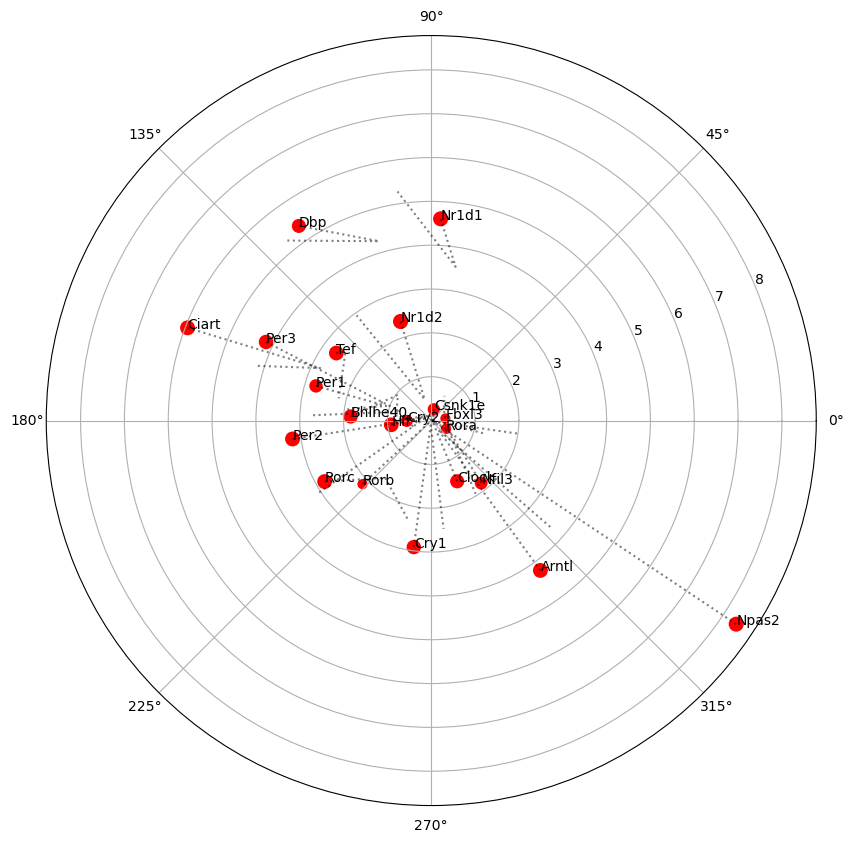

In [109]:


fig, ax = plt.subplots(figsize=(10,10),subplot_kw={'projection': 'polar'})

# connect same gene proseq log_tpm to pre-mRNA to mRNA with thin line
for g in circadian_core_genes.index:
    ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['premrna'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')

colors = {'mrna':'blue','premrna':'green','proseq_logtpm':'red'}
for i in Phase_amp:
    ax.scatter(Phase_amp[i].phase,Phase_amp[i].amplitude,s=Phase_amp[i].R2*100,label=i,color=colors[i],marker='o')
    # add names
    for g in Phase_amp[i].index:
        ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g)

    
ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
ax.set_yticks([])
ax.set_theta_zero_location("N")  # theta=0 at the top
ax.set_theta_direction(-1)  # theta increasing clockwise
ax.set_yscale('log')

# Make legend to show the color of the different lines and the size corresponding to R2 and put it outside
#for i in colors:
#    ax.scatter([],[],s=50,label=i,color=colors[i],marker='o')
for r2 in [0.25,0.5,0.75,1]:
    ax.scatter([],[],s=r2*100,label=fr'$R^2={r2:.2f}$',color='black',marker='o')
ax.legend(loc='upper right')



# plot all phase and amplitude in a polar plot
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5,nrows*5))

t_ = np.linspace(22,72,100,endpoint=True)

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['mrna','premrna']:
        T_ = np.arange(22,65,6)
        ax.plot(T_,rnaseq[i].loc[g],'.',label=i,color=colors[i])
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    i = 'proseq_logtpm'
    T_ = np.arange(0,48,4) + 24
    ax.plot(T_,log_tpm.loc[g],'.',label=i,color=colors[i])
    # plot harmonic fit
    [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
    f_ = mu + 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
    ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(np.arange(0,48,4)+24)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.set_title(g)
fig.tight_layout()


# plot all phase and amplitude in a polar plot centered on the mean expression
fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5,nrows*5))

for f in range(circadian_core_genes.shape[0]):
    ax = axes[f//ncols,f%ncols]
    g = circadian_core_genes.index[f]
    for i in ['mrna','premrna']:
        T_ = np.arange(22,65,6)
        ax.plot(T_,rnaseq[i].loc[g] - rnaseq[i].loc[g].mean(),'.',label=i,color=colors[i])
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    i = 'proseq_logtpm'
    T_ = np.arange(0,48,4) + 24
    ax.plot(T_,log_tpm.loc[g] - log_tpm.loc[g].mean(),'.',label=i,color=colors[i])
    # plot harmonic fit
    [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
    f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
    ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}',color=colors[i])

    if f//ncols == nrows-1:
        ax.set_xlabel('Time (h)')
        ax.set_xticks(np.arange(0,48,4)+24)
    else:
        ax.set_xticks([])

    if f%ncols == 0:
        ax.set_ylabel('log2(TPM+1)')
    
    ax.set_title(g)
fig.tight_layout()

0
2
4
6
8
10
12


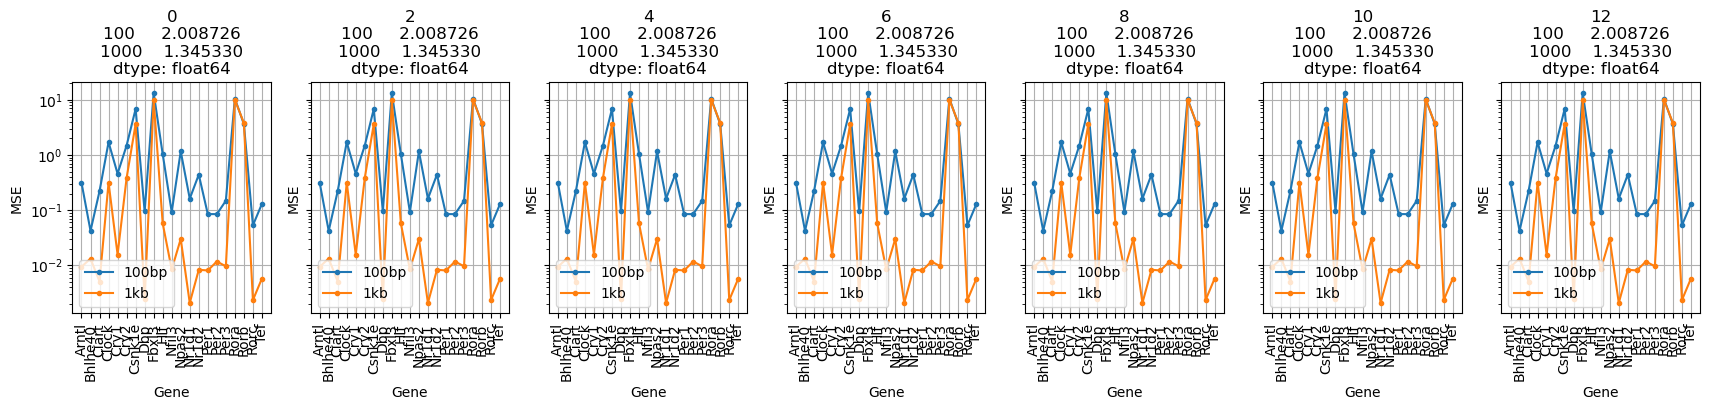

In [129]:

# sum counts in gene body
samples = [f'CT{t:02d}' for t in T]
tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
tpm.columns = samples
tpm.index = proseq.keys()
log_tpm = pd.DataFrame(np.zeros((len(proseq),len(samples))))
for g in proseq:
    tpm.loc[g] = proseq[g].fillna(0).sum(0)
    log_tpm = np.log2(tpm+1)

Phase_amp['proseq_logtpm'] = pd.DataFrame( np.zeros((len(proseq),5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
Phase_amp['proseq_logtpm'].index = circadian_core_genes.index

# Fourrier transform
T = np.arange(0,48,4)
N = len(T)
P = 24
n = 1
ω_n = 2*np.pi*n/P
x = log_tpm.values
φ_n, a_n, R2, pval, mu = FourierTransform(x,T,ω_n)

# make table
Phase_amp['proseq_logtpm'].loc[:,'phase'] = φ_n
Phase_amp['proseq_logtpm'].loc[:,'amplitude'] = a_n
Phase_amp['proseq_logtpm'].loc[:,'R2'] = R2
Phase_amp['proseq_logtpm'].loc[:,'pval'] = pval
Phase_amp['proseq_logtpm'].loc[:,'mean_log_expression'] = mu

# get phase and amplitude of per bind
Bin_size = [100,1000]

frac_of_nan_max = np.arange(0,N+1,2)
MSE = {}
for f_nan in frac_of_nan_max:
    print(f_nan)
    binned_proseq = {}
    MSE[f_nan] = pd.DataFrame( np.zeros((len(circadian_core_genes),len(Bin_size))) )
    MSE[f_nan].index = circadian_core_genes.index
    MSE[f_nan].columns = Bin_size

    for bin_size in Bin_size:
        Phase_amp[f'proseq_logtpm_{bin_size}'] = {}
        binned_proseq[bin_size] = {}

        for g in circadian_core_genes.index:
            
            x = proseq[g]
            
            b0 = x.index[0] - x.index[0] % bin_size
            b1 = x.index[-1] - x.index[-1] % bin_size + bin_size
            bins = np.arange(b0,b1+1,bin_size)

            bin_idx = np.digitize(x.index,bins) - 1
            x = x.groupby(bin_idx).sum()
            my_index = []
            for i in range(len(x)):
                my_index.append(f'{bins[i]}-{bins[i+1]}')
            x.index = my_index

            # keep only bins with less than 2 thirds nan values (at least 4 time points with data)
            n = np.isnan( x.values ).sum()
            if n>0:
                print(f'{g} has {n} nan values')
            idx_in = np.isnan( x.values ).sum(1) <= f_nan
            x = x[idx_in]
            x = x.fillna(0)

            x = np.log2(x+1)
            binned_proseq[bin_size][g] = x
            
            
            φ_n, a_n, R2, pval, mu = FourierTransform(x.values,T,ω_n)

            # make table
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g] = pd.DataFrame( np.zeros((x.shape[0],5)), columns=['phase','amplitude','R2','pval','mean_log_expression'])
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].index = x.index
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'phase'] = φ_n
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'amplitude'] = a_n
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'R2'] = R2
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'pval'] = pval
            #Phase_amp[f'proseq_logtpm_{bin_size}'][g].loc[:,'mean_log_expression'] = mu

            MSE[f_nan].loc[g,bin_size] = np.mean( (φ_n - Phase_amp['proseq_logtpm'].loc[g,'phase'])**2 )


# Plot mean square difference between bin pases and gene phase
fig, axes = plt.subplots(1,7,figsize=(21,3),sharey=True)
for f_nan in frac_of_nan_max:
    ax = axes[f_nan//2]
    ax.plot(MSE[f_nan].loc[:,100],'.-')
    ax.plot(MSE[f_nan].loc[:,1000],'.-')
    ax.set_yscale('log') 
    ax.grid('on')
    ax.set_xlabel('Gene')
    ax.set_ylabel('MSE')
    ax.set_xticks(np.arange(len(MSE[f_nan])))
    ax.set_xticklabels(MSE[f_nan].index,rotation=90)
    ax.legend(['100bp','1kb'])
    ax.set_title(f'{f_nan}\n{MSE[f_nan].mean(0)}')





In [130]:
            x = proseq[g]
            
            b0 = x.index[0] - x.index[0] % bin_size
            b1 = x.index[-1] - x.index[-1] % bin_size + bin_size
            bins = np.arange(b0,b1+1,bin_size)

            bin_idx = np.digitize(x.index,bins) - 1
            x = x.groupby(bin_idx).sum()

In [131]:
x

,CT00,CT04,CT08,CT12,CT16,CT20,CT24,CT28,CT32,CT36,CT40,CT44
0,112.15444,473.476848,581.978830,362.997784,247.64643,203.95732,113.290936,287.155328,449.278312,513.382765,427.05486,137.259903
1,262.89981,1514.543130,4241.692496,1516.910238,877.79600,950.90012,315.471578,1241.611862,3257.632634,2218.841610,755.08314,383.183490
2,80.79939,245.857898,1323.853164,659.247892,185.12189,47.27487,74.074824,327.327392,1003.192978,427.053510,225.28698,40.851135
3,103.71281,356.019584,1198.717452,504.722486,250.09843,122.91459,68.845982,406.183432,1066.121134,663.080905,341.64376,195.268486
4,94.06497,512.872752,1579.089584,1094.479388,398.44110,191.80092,176.036550,508.845240,1271.735734,955.130200,276.03832,165.038584
5,179.68834,746.328038,1941.584804,974.699466,606.85653,239.07581,168.193492,583.981856,1963.945602,1227.893325,409.72498,267.166380
6,133.86183,428.244942,1322.859794,690.335692,411.92665,126.96686,81.046542,383.121936,1155.391452,844.004485,318.12480,170.757722
7,162.80489,537.677314,1487.720636,716.851952,561.49544,121.56398,174.293712,568.359298,1211.734216,889.923980,368.87648,201.804442
8,504.09222,1484.631416,3570.332436,2618.704890,1621.96166,728.03313,516.780996,1664.162124,3847.401958,2881.003630,1512.64064,894.639518
9,1860.79958,4502.043440,12105.362438,7683.301700,4890.40452,2061.18498,1169.510644,5633.006954,11540.010762,9566.920400,4378.23990,2362.012754


In [80]:
np.arange(0,N+1,2)

array([ 0,  2,  4,  6,  8, 10, 12])

In [ ]:

# plot all phase and amplitude in a polar plot
colors = {'proseq_logtpm':'blue',
          'premrna':'green',
          'mrna':'red'}
t_ = np.linspace(0,48,100,endpoint=True)        
for bin_size in Bin_size:

    fig, axes = plt.subplots(ncols=ncols, nrows=nrows, figsize=(ncols*5,nrows*5))
    for f in range(circadian_core_genes.shape[0]):
        ax = axes[f//ncols,f%ncols]
        g = circadian_core_genes.index[f]
        i = 'proseq_logtpm'
        
        ax.plot(T,log_tpm.loc[g]-log_tpm.loc[g].mean(),'x')
        # plot harmonic fit
        [mu, a_n, φ_n] = Phase_amp[i].loc[g,['mean_log_expression','amplitude','phase']]
        f_ = 0.5 * a_n * np.cos(ω_n * t_ - φ_n)
        ax.plot(t_,f_, label=f'phi={φ_n/ω_n :.2f}')
    
        T_ = np.repeat(T[None,:],binned_proseq[bin_size][g].shape[0],0)
        y = binned_proseq[bin_size][g].values - binned_proseq[bin_size][g].values.mean(1)[:,None]
        ax.scatter(T_,y,marker='.',alpha=0.1,color='black')
        ax.plot(T,y.mean(0),'o')
        if f//ncols == nrows-1:
            ax.set_xlabel('Time (h)')
            ax.set_xticks(T)
        else:
            ax.set_xticks([])
        if f%ncols == 0:
            ax.set_ylabel('log2(TPM+1)')
        
        ax.set_title(g)
    fig.tight_layout()


    # plot all phase and amplitude in a polar
    fig, axes = plt.subplots(ncols=ncols, nrows=nrows,figsize=(ncols*5,nrows*5),subplot_kw={'projection': 'polar'})
    for f,g in enumerate(circadian_core_genes.index):
        ax = axes[f//ncols,f%ncols]

        # connect same gene proseq log_tpm to pre-mRNA to mRNA with thin line
        ax.plot([Phase_amp['proseq_logtpm'].loc[g].phase,Phase_amp['premrna'].loc[g].phase,Phase_amp['mrna'].loc[g].phase], [Phase_amp['proseq_logtpm'].loc[g].amplitude,Phase_amp['premrna'].loc[g].amplitude,Phase_amp['mrna'].loc[g].amplitude], color='black', alpha=0.5,linestyle=':')
        # add gene phase amd and names
        for i in colors:
            ax.scatter(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,s=Phase_amp[i].loc[g].R2*100,label=i,color=colors[i],marker='o')
            #ax.text(Phase_amp[i].loc[g].phase,Phase_amp[i].loc[g].amplitude,g)


        i = f'proseq_logtpm_{bin_size}'
        # color point from start to end
        pos = np.array( [np.array(i.split('-')).astype(int).mean() for i in binned_proseq[bin_size][g].index] )
        # bound in [0,1]
        pos = (pos - pos[0]) / (pos[-1] - pos[0])

        if circadian_core_genes.at[g,'strand'] == '-':
            pos = 1 - pos
        ax.scatter(Phase_amp[i][g].phase,Phase_amp[i][g].amplitude,s=Phase_amp[i][g].R2*10,label=i,c=pos,marker='o',alpha=0.5,cmap=cm.jet)
        # add names at the average position
        #ax.text(Phase_amp[i][g].phase.mean(),Phase_amp[i][g].amplitude.mean(),g,fontsize=6)
            
        ax.set_xticks(np.linspace(0,2*np.pi,12,endpoint=False) )
        ax.set_xticklabels([f'{t}h' for t in np.arange(0,24,2)])
        ax.set_yticks([])
        ax.set_theta_zero_location("N")  # theta=0 at the top
        ax.set_theta_direction(-1)  # theta increasing clockwise
        ax.set_yscale('log')

        ax.set_title(g)
    fig.tight_layout()

